# Demo 1: Stacking

In this demo of code for stacking in ensemble model, we will make some base learners as following: KNN, SVM.SVC, Logistic Regression, Naive Bayes, Decision_Tree. Then construct an ensemble model by stacking those base learners

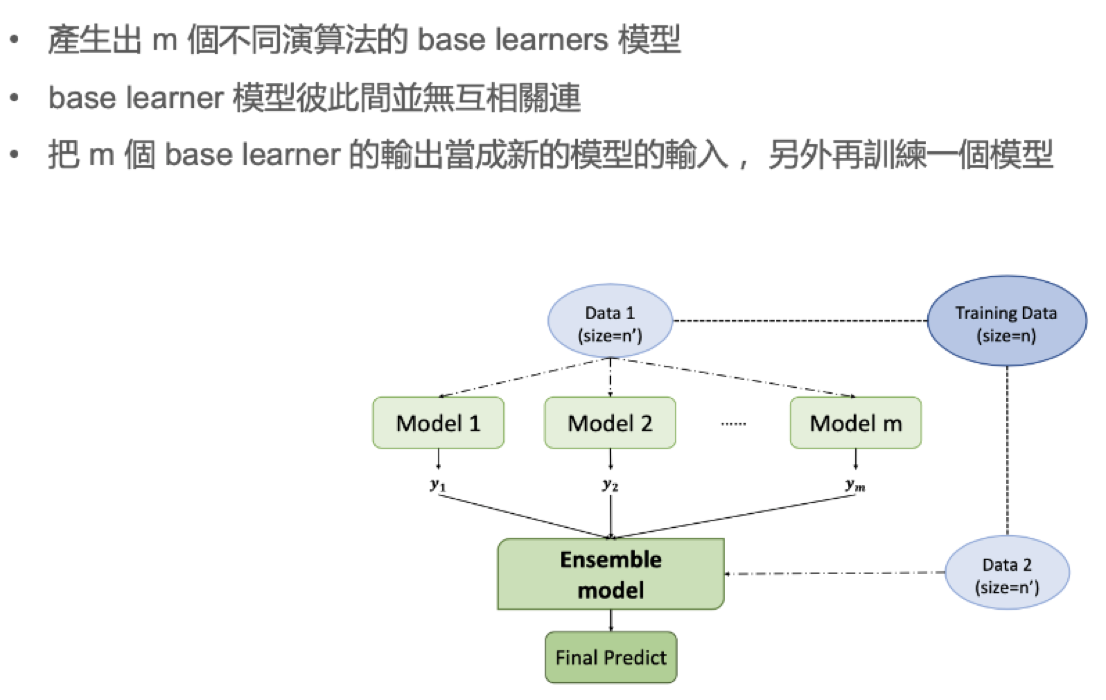

The stacking model in this demo will also try to solve the classification problem as we have done before in the section S1_Classification:

-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library package:
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree,...)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set) or using the cross validation to evaluate the performance of model
## 1. Task 1: Base laerners:
-   KNN, SVC, Naive Bayes, Decisio Tree, Logistic Regression
-   Make a cross validation score to compare performance of each model.
## 2. Task 2: Stacking model
-   Define a stacking model from base laerners
-   Training model on our trainset
-   Evaluating the performance of trained model on the testset
## 3. Task 3: Evaluating the performance by Cross Validation method
-   Evaluate the performance of stacking model by comput the cross validation score
*****************************************************************************

# Import all packages

In [22]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
# import models
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
# import stacking
from sklearn.ensemble import StackingClassifier

# import method to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay


## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [2]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [3]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [4]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 28
height = 28
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

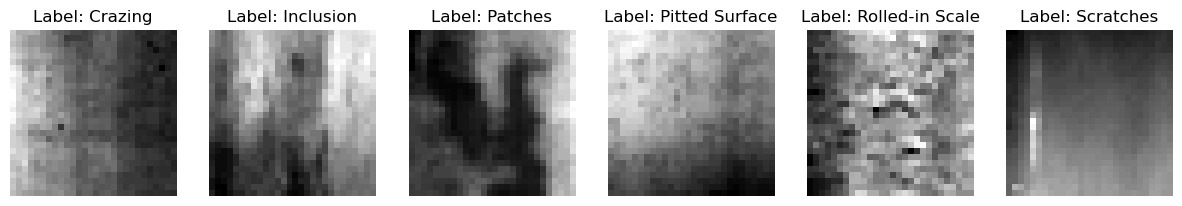

In [5]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 28 x 28 pixels. Each pixels is one feature of sample, so totally we have 28*28 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [6]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255

### 0.4. Deviding our dataset to trainset and testset

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

## 1. Task 1: Base Learners
### 1.1. Getting the base learners
Define a function to get a list of some base learners where each learner can individually solve the classification.

In [8]:
# Define a function to get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression(solver='lbfgs',max_iter=1000)
    models['knn'] = KNeighborsClassifier(n_neighbors=3)
    models['dtree'] = DecisionTreeClassifier(criterion='gini')
    models['svm'] = SVC(C=10,kernel='rbf')
    models['bayes'] = MultinomialNB()
    return models

### 1.2. Evaluating the performance of each base learners
We will use the cross validation score to evaluate the performance. Here, we are using the whole dataset.

As simple excercise, you may devide the dataset to trainset and testset then apply the cross validation on the trainset to adjust the hyperparameters to get best model, then evaluate the performance on the testset. You may have more information about the evaluation performance.

In [9]:
# Define a function with input is model data input (X), label (y), 
# then compute the cross validation score for model with kfold = 10
# Repeat this 3 times, n_repeats = 3
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
    scores = cross_val_score(model,X,y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=1,
                             error_score='raise')
    return scores

Model name lr, mean of cv score: 0.4996296296296296, std of cv score: 0.0297774092477656
Model name knn, mean of cv score: 0.569814814814815, std of cv score: 0.03170995525072125
Model name dtree, mean of cv score: 0.6025925925925927, std of cv score: 0.029141817751096696
Model name svm, mean of cv score: 0.7909259259259259, std of cv score: 0.03485665334737221
Model name bayes, mean of cv score: 0.3125925925925926, std of cv score: 0.03712766689187485


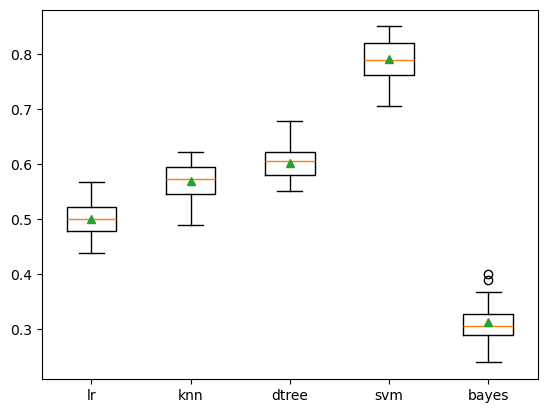

In [10]:
# Get the models to evaluate
models = get_models()
# Evaluate the models, store results, visualize results
results, names = list(),list()
for name, model in models.items():
    scores = evaluate_model(model,X,y)
    results.append(scores)
    names.append(name)
    print(f"Model name {name}, mean of cv score: {np.mean(scores)}, std of cv score: {np.std(scores)}")
plt.boxplot(results,labels=names,showmeans=True)
plt.show()

## 2. Task 2: Stacking model
In this task we combine these five models into a single model using stacking.

We can use a logistic regression model to learn how to best combine the predictions from each of the separate five models.

We will use the StackingClassifier model in sklearn.ensemble package

### 2.1. Define a stacking model
Define a function get_stacking to get a stacking model

In [11]:
# Define a function to get a stacking model
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(("lr",LogisticRegression(solver='lbfgs',max_iter=1000)))
    level0.append(("knn",KNeighborsClassifier(n_neighbors=3)))
    level0.append(("dtree",DecisionTreeClassifier(criterion='gini')))
    level0.append(('svm',SVC(C = 10,kernel='rbf')))
    level0.append(('bayes',MultinomialNB()))
    # define meta learner model
    level1 = LogisticRegression(solver='lbfgs',max_iter=1000)
    # level1 = SVC(C = 10,kernel='rbf')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0,final_estimator=level1,cv = 5)
    return model

In [12]:
# Use the function to get a stacking model 
stacking_model = get_stacking()

### 2.2. Training model on our trainset

In [18]:
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('dtree', DecisionTreeClassifier()),
                               ('svm', SVC(C=10)), ('bayes', MultinomialNB())],
                   final_estimator=LogisticRegression(max_iter=1000))

### 2.3. Evaluating the performance of trained model on the testset

In [19]:
# Predict on testset:
pred_test = stacking_model.predict(X_test)

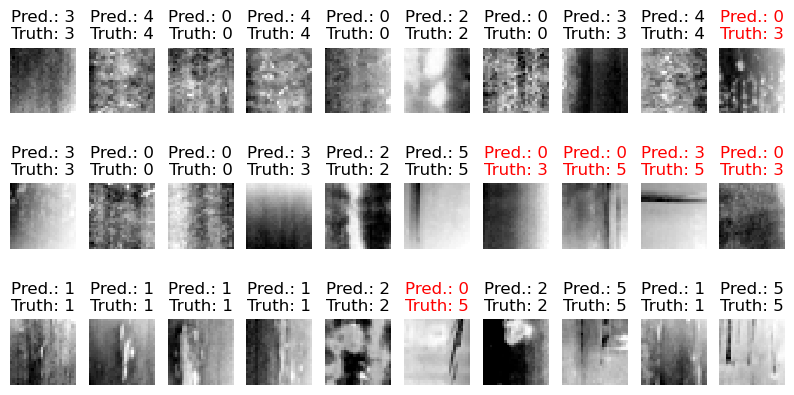

In [20]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

In [21]:
# Classification report:
print(f"Classification report for classifier {stacking_model}:\n"
      f"{classification_report(y_test,pred_test,digits=4)}\n")

Classification report for classifier StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('dtree', DecisionTreeClassifier()),
                               ('svm', SVC(C=10)), ('bayes', MultinomialNB())],
                   final_estimator=LogisticRegression(max_iter=1000)):
              precision    recall  f1-score   support

           0     0.7671    0.8615    0.8116        65
           1     0.7581    0.7015    0.7287        67
           2     0.9400    1.0000    0.9691        47
           3     0.8551    0.8551    0.8551        69
           4     0.7143    0.7778    0.7447        45
           5     0.8246    0.7015    0.7581        67

    accuracy                         0.8083       360
   macro avg     0.8099    0.8162    0.8112       360
weighted avg     0.8089    0.8083    0.8067       360




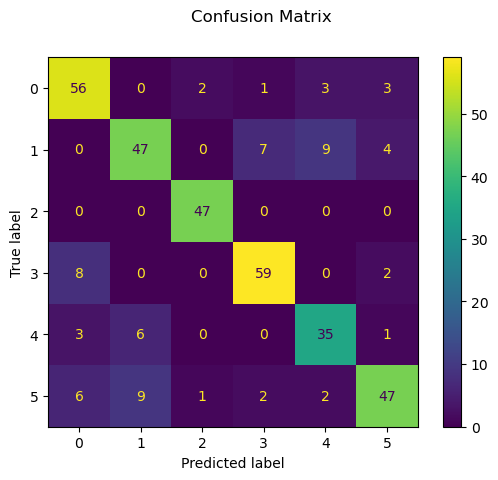

In [23]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 3. Task 3: Evaluating the performance of stacking model
Using the evalate_model (cross validation with repeating) in the previous section to compute the cv score of stacking model.

Visulize results of 5 base learners from previous section and the stacking model.

In [13]:
# Evaluate the models and store results
cv_stack_model = get_stacking()
stacking_scores = evaluate_model(cv_stack_model,X,y)

In [14]:
results = results[:5]
names = names[:5]

In [15]:
# add results of stacking model to list scores
# add name of stacking model to list name
results.append(stacking_scores)
names.append("stacking")

Model name lr, mean of cv score: 0.4996296296296296, std of cv score: 0.0297774092477656
Model name knn, mean of cv score: 0.569814814814815, std of cv score: 0.03170995525072125
Model name dtree, mean of cv score: 0.6025925925925927, std of cv score: 0.029141817751096696
Model name svm, mean of cv score: 0.7909259259259259, std of cv score: 0.03485665334737221
Model name bayes, mean of cv score: 0.3125925925925926, std of cv score: 0.03712766689187485
Model name stacking, mean of cv score: 0.8292592592592593, std of cv score: 0.02728953632561281


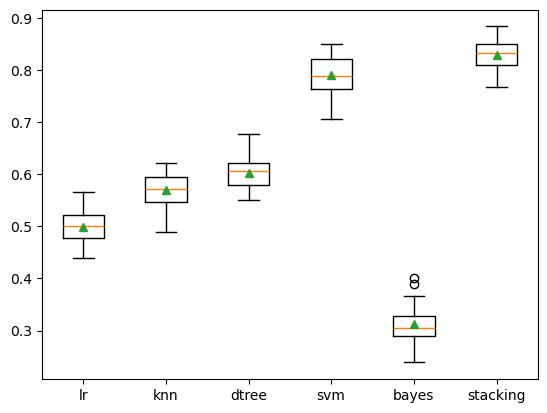

In [16]:
for name, scores in zip(names,results):
    print(f"Model name {name}, mean of cv score: {np.mean(scores)}, std of cv score: {np.std(scores)}")
plt.boxplot(results,labels=names,showmeans=True)
plt.show()